In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from edmkit.util import autocorrelation, dtw
from edmkit.ccm import search_best_embedding
from edmkit.simplex_projection import simplex_projection
from edmkit.tensor import Tensor, dtypes
from edmkit.embedding import lagged_embed
import tqdm
from safetensors.numpy import load_file, save_file
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from edmkit.ccm import calculate_rho
from edmkit.util import pad, pairwise_distance, topk
from umap import UMAP
import polars as pl

In [2]:
rng = np.random.default_rng()

In [3]:
data = h5.File("../data/dentate_gyrus.h5", "r")

In [4]:
data["voltages"].keys()

basket_cells = data["voltages"]["Population(BasketCell)#1"]
glanule_cells = data["voltages"]["Population(GlanuleCell)#1"]
hipp_cells = data["voltages"]["Population(HippCell)#1"]
mossy_cells = data["voltages"]["Population(MossyCell)#1"]

In [5]:
basket_cells = np.stack(basket_cells)
glanule_cells = np.stack(glanule_cells)
hipp_cells = np.stack(hipp_cells)
mossy_cells = np.stack(mossy_cells)

In [6]:
cell_types = ["basket_cells", "glanule_cells", "hipp_cells", "mossy_cells"]

In [7]:
def filter_cells_include_nan(cells):
    return cells[~np.isnan(cells).any(axis=1)]


populations = {cell_type: filter_cells_include_nan(locals()[cell_type]) for cell_type in cell_types}

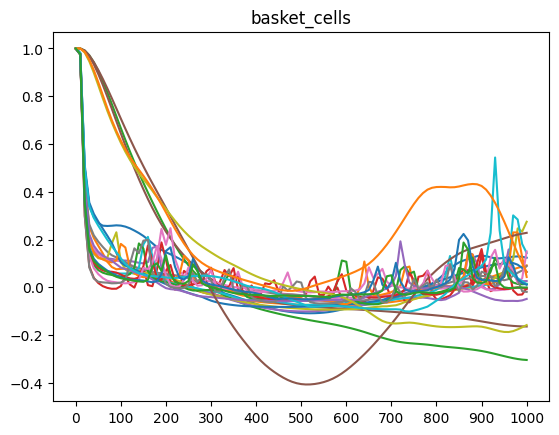

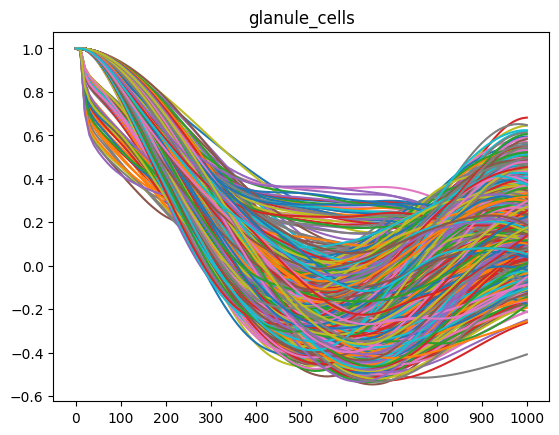

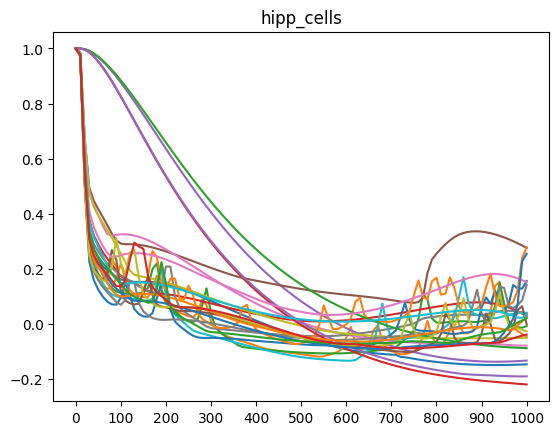

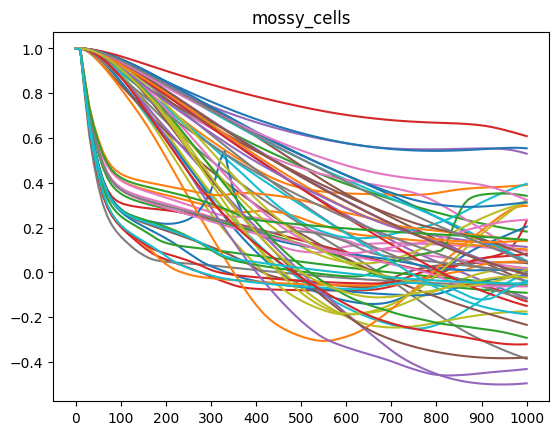

In [8]:
for cell_type in cell_types:
    corrs = [autocorrelation(cell, 1000, 10) for cell in populations[cell_type]]
    corrs = np.array(corrs)

    for i in range(corrs.shape[0]):
        plt.plot(corrs[i])
        plt.xticks(np.arange(0, 100 + 1, 10), np.arange(0, 1000 + 1, 100))

    plt.title(cell_type)
    plt.show()

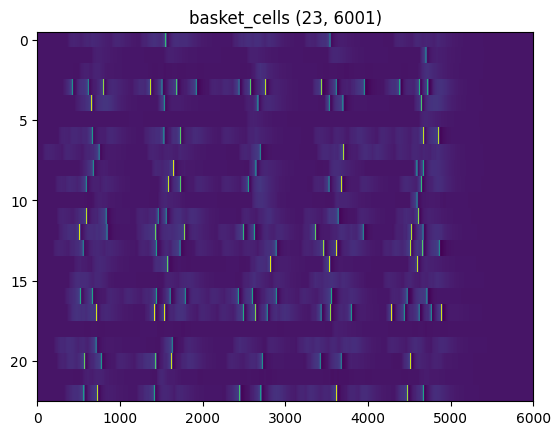

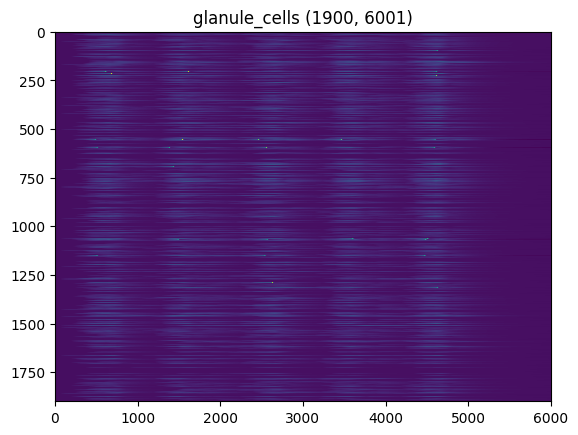

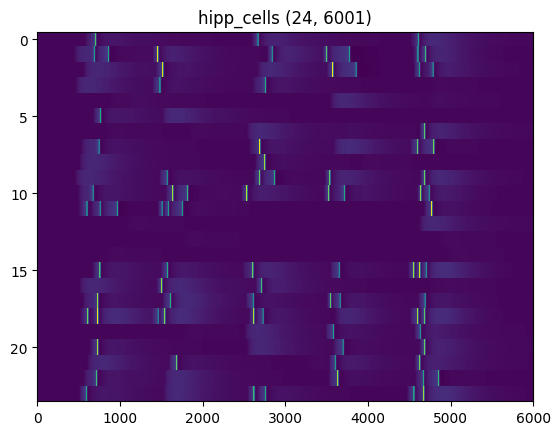

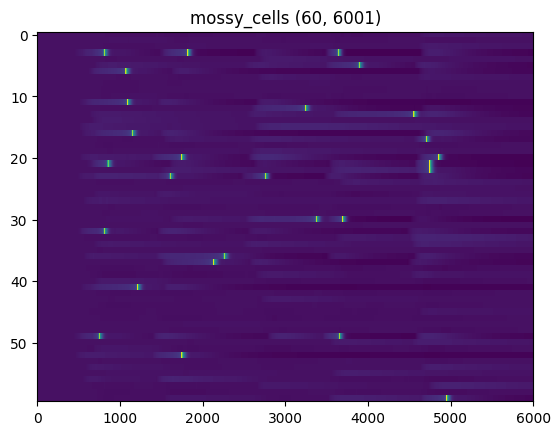

In [9]:
for cell_type in cell_types:
    population = populations[cell_type]
    plt.imshow(population, aspect="auto", interpolation="none")
    plt.title(f"{cell_type} {population.shape}")
    plt.show()

In [10]:
cells = glanule_cells[:20]
N = cells.shape[0]

corr_distance = np.zeros((N, N))

with tqdm.tqdm(total=N * N) as pbar:
    for i in range(N):
        for j in range(N):
            corr_distance[i, j] = np.corrcoef(cells[i], cells[j])[0, 1]
            pbar.update(1)

dtw_distance = np.zeros((N, N))

cells = Tensor(cells, dtype=dtypes.float32)
cells = cells.reshape(N, -1, 1)

with tqdm.tqdm(total=N * N) as pbar:
    for i in range(N):
        for j in range(N):
            dtw_distance[i, j] = dtw(cells[i], cells[j])
            pbar.update(1)

100%|██████████| 400/400 [07:06<00:00,  1.07s/it]


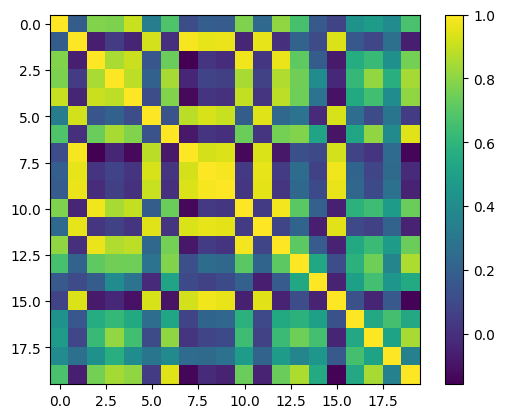

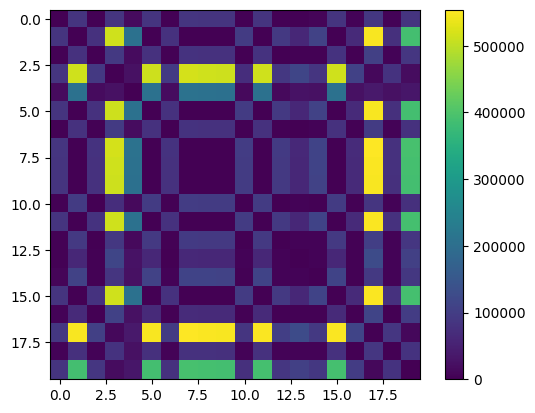

In [11]:
plt.imshow(corr_distance)
plt.colorbar()
plt.show()

plt.imshow(dtw_distance)
plt.colorbar()
plt.show()

In [12]:
Tp = 400
tau_list = list(range(1, 100 + 1, 10))
e_list = list(range(1, 5 + 1))

In [13]:
# X = lagged_embed(glanule_cells[0], 40, 10)
X = glanule_cells[:20].T
print(X.shape)
Y = X[Tp:]
X = X[:-Tp]

t = np.arange(len(X) // 2, len(X))
partition = len(X) // 2

obserbations, predictions = simplex_projection(X, Y, t, partition)

(6001, 20)


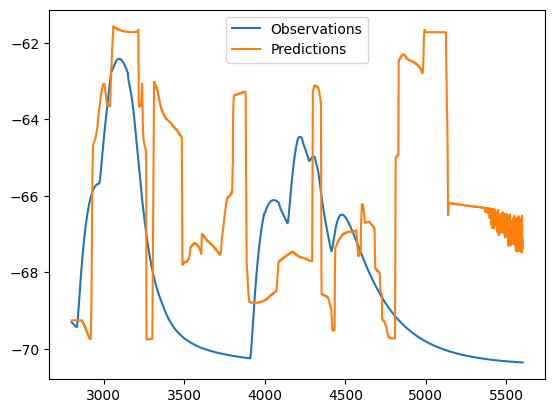

In [14]:
plt.plot(t, obserbations[:, 0], label="Observations")
plt.plot(t, predictions[:, 0], label="Predictions")

plt.legend()
plt.show()

In [15]:
np.corrcoef(obserbations[:, 0], predictions[:, 0])

array([[1.        , 0.12915484],
       [0.12915484, 1.        ]])

100%|██████████| 23/23 [00:03<00:00,  6.54it/s]


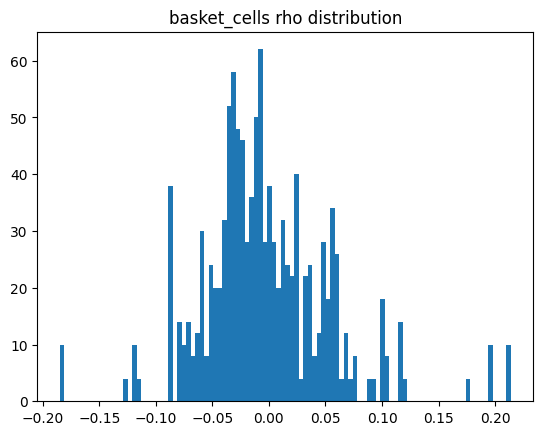

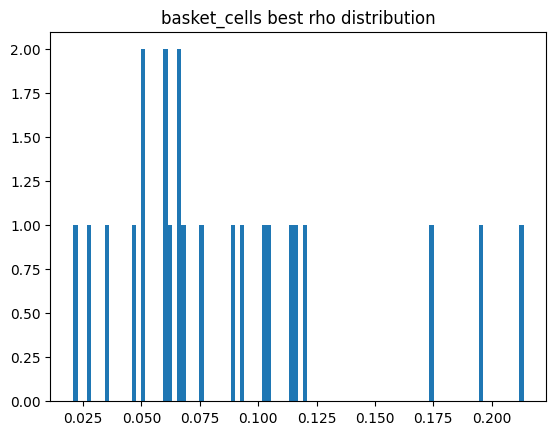

100%|██████████| 1900/1900 [04:52<00:00,  6.50it/s]


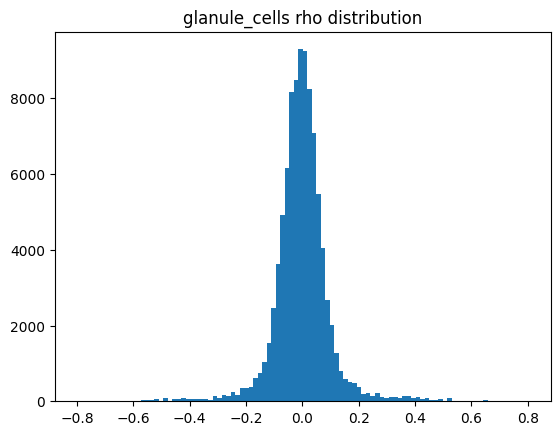

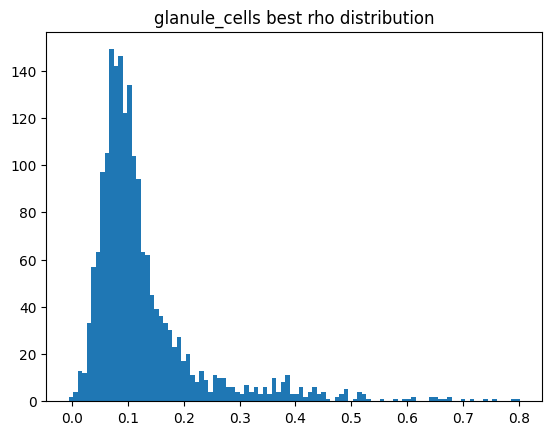

100%|██████████| 24/24 [00:03<00:00,  6.49it/s]


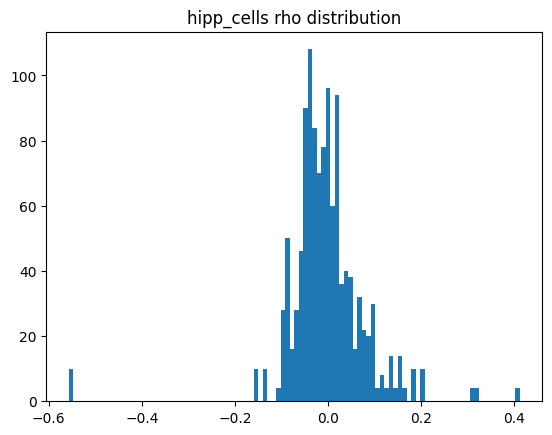

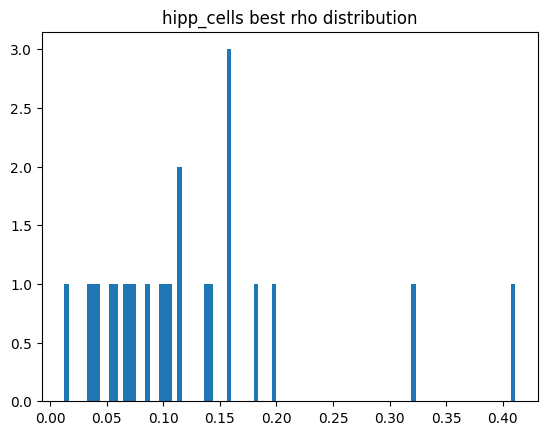

100%|██████████| 60/60 [00:09<00:00,  6.47it/s]


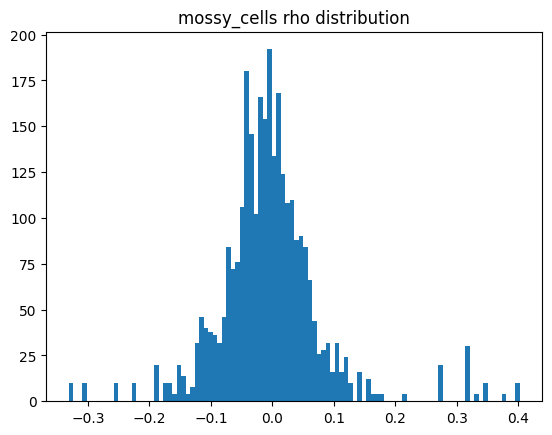

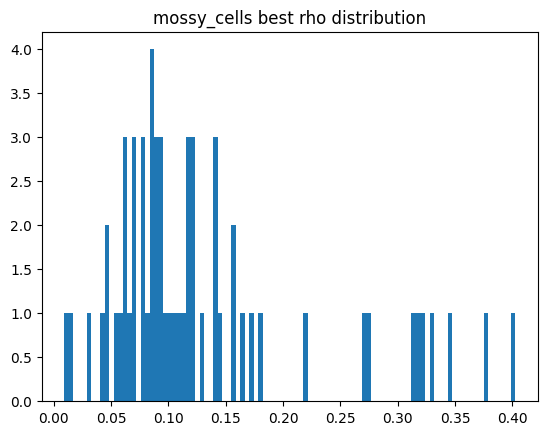

In [16]:
rhos = dict()
best_tau_e = dict()

for cell_type in cell_types:
    population = populations[cell_type]
    rho_matrix = np.zeros((len(population), len(tau_list), len(e_list)))

    with tqdm.tqdm(total=len(population)) as pbar:
        for i, cell in enumerate(population):
            rho_matrix[i] = search_best_embedding(cell, tau_list, e_list, Tp, max_L=1000, rng=rng)
            pbar.update(1)

    rhos[cell_type] = rho_matrix

    plt.hist(rho_matrix.flatten(), bins=100)
    plt.title(f"{cell_type} rho distribution")
    plt.show()

    best_rho_indices = [np.unravel_index(np.argmax(rho, axis=None), rho.shape) for rho in rho_matrix]
    best_rhos = [rho[index] for rho, index in zip(rho_matrix, best_rho_indices)]

    plt.hist(best_rhos, bins=100)
    plt.title(f"{cell_type} best rho distribution")
    plt.show()

    best_tau_e[cell_type] = [(tau_list[i], e_list[j]) for i, j in best_rho_indices]

In [17]:
cells = np.zeros((0, 2000))

for cell_type in cell_types:
    population = populations[cell_type]
    cells = np.vstack((cells, population[:20, rng.choice(population.shape[1], 2000, replace=False)]))

In [18]:
best_tau_list = []
best_e_list = []

for cell_type in cell_types:
    for tau, e in best_tau_e[cell_type][:20]:
        best_tau_list.append(tau)
        best_e_list.append(e)

In [19]:
min_L = 2000 - (max(best_e_list) - 1) * max(best_tau_list)

embeddings = [lagged_embed(cell, tau, e)[-min_L:] for cell, tau, e in zip(cells, best_tau_list, best_e_list)]

X = pad(embeddings)  # X.shape == (len(tau_list) * len(e_list), min_L, max(e_list))
D = pairwise_distance(Tensor(X, dtype=dtypes.float32)).numpy()

L = min_L
seq = np.arange(L)
lib_size = L // 2

N = X.shape[0]

rho = np.zeros((N, N))

samples_indecies = np.arange(lib_size, L)

with tqdm.tqdm(total=N * N) as pbar:
    for i in range(N):
        for j in range(N):
            observations = X[i, samples_indecies, : best_e_list[i]]
            predictions = np.zeros((len(samples_indecies), best_e_list[j]), dtype=embeddings[0].dtype)

            for k, t in enumerate(samples_indecies):
                # [0, 1, 2, 3, 4 | 5, 6, 7, 8, 9, 10]; initialize mask, `|` separates lib and test
                mask = np.ones(L, dtype=bool)

                # [0, 1, 2, 3, 4 | 5, F, 7, 8, 9, 10], t = 6; exclude self
                mask[t] = False

                # [0, 1, 2, 3, 4 | 5, F, 7, 8, F, F ], Tp = 2; exclude last Tp points to prevent out-of-bound indexing on predictions
                mask[-Tp:] = False

                # [0, 1, 2, 3, 4 | F, F, F, F, F, F ], lib_size = 5; exclude test points
                mask[lib_size:] = False

                # find k(=e+1) nearest neighbors in phase space for simplex projection
                indices_masked, _ = topk(D[i, t, mask], best_e_list[i] + 1, largest=False)
                indices = seq[mask][indices_masked]
                predictions[k] = X[j, indices, : best_e_list[j]].mean()

            ground_truth = X[j, samples_indecies, : best_e_list[j]]

            rho[i, j] = calculate_rho(ground_truth, predictions)
            pbar.update(1)

100%|██████████| 6400/6400 [18:46<00:00,  5.68it/s]   


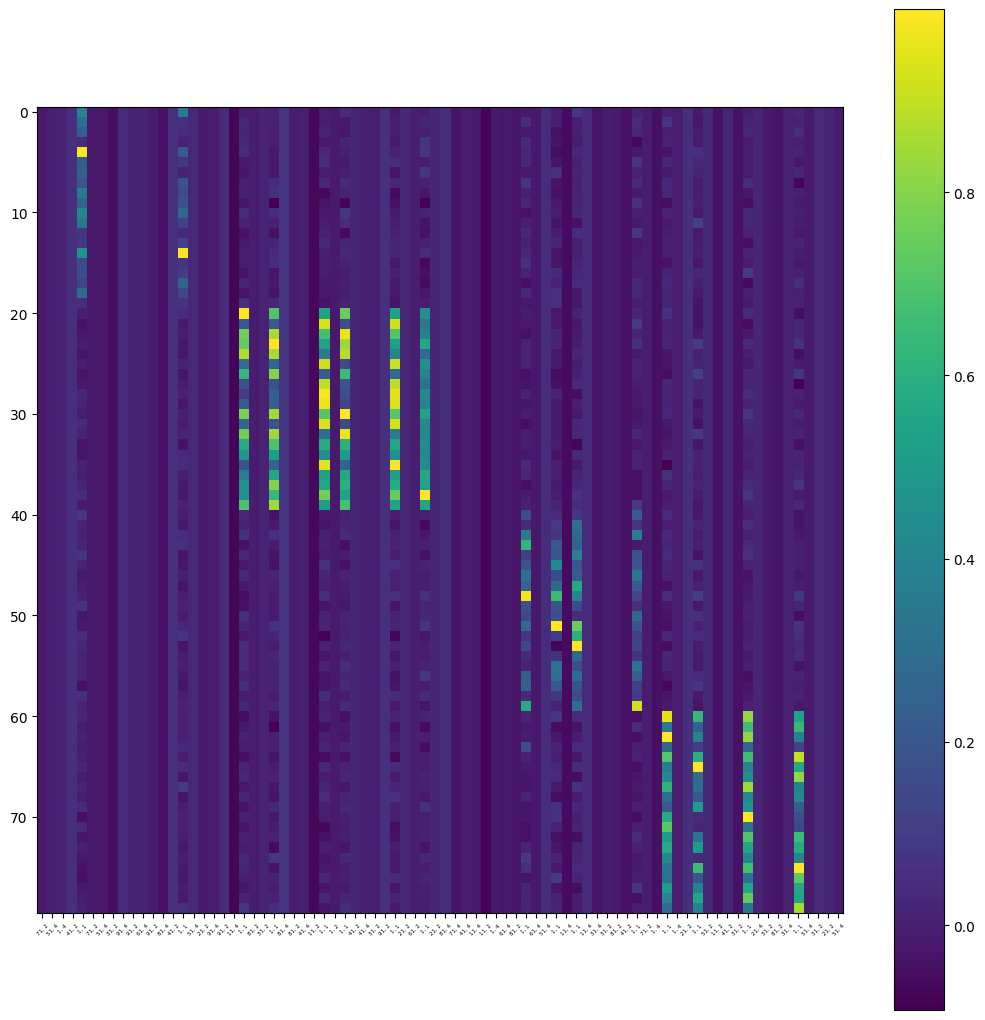

In [20]:
plt.figure(figsize=(13, 13))
plt.imshow(rho)
plt.xticks(np.arange(N), [f"{tau}, {e}" for tau, e in zip(best_tau_list, best_e_list)], fontsize=4, rotation=45)
plt.colorbar()

/Users/temma/Repositories/LabRotations/CHAOS/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


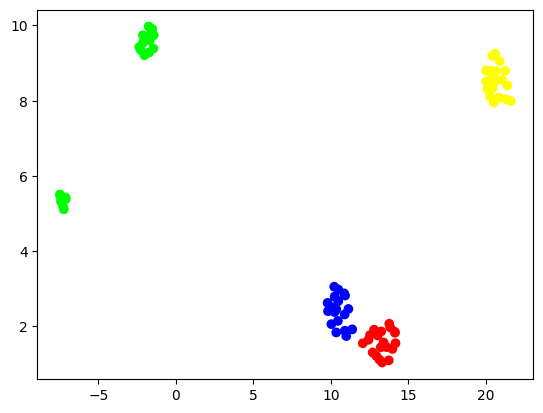

In [21]:
embedding = UMAP(n_components=2).fit_transform(rho)

colors = np.zeros((N, 3))
colors[:20, 0] = 1
colors[20:40, 1] = 1
colors[40:60, 2] = 1
colors[60:80, 0] = 1
colors[60:80, 1] = 1

plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)


In [22]:
regions = pl.read_excel("../data/Regions/Fly brain areas 08-26-2020.xlsx", has_header=False)
gsb1_ts = pl.read_csv("../data/Regions/gsb1RegionsTS.csv", has_header=False)
gsb1_reg = pl.read_csv("../data/Regions/gsb1Regressors.csv", has_header=False)

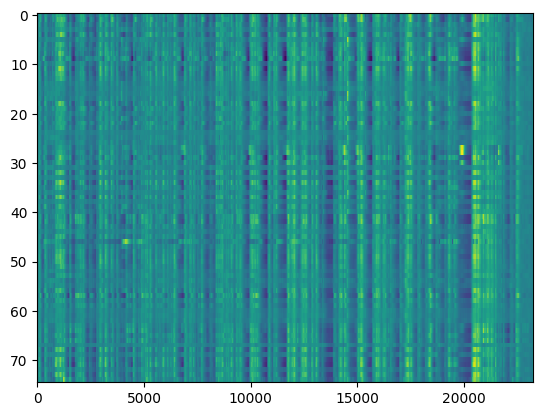

In [23]:
plt.imshow(gsb1_ts.to_numpy().T, aspect="auto", interpolation="none");

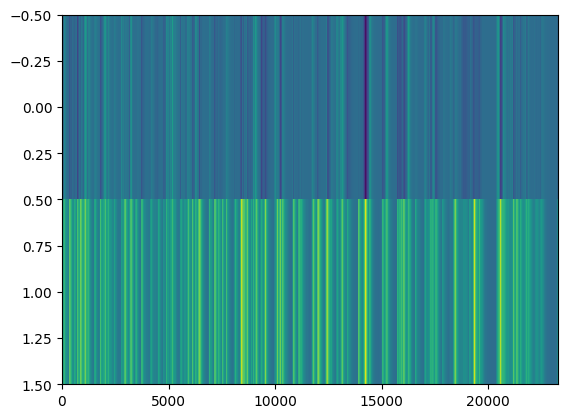

In [24]:
plt.imshow(gsb1_reg.to_numpy().T, aspect="auto", interpolation="none");

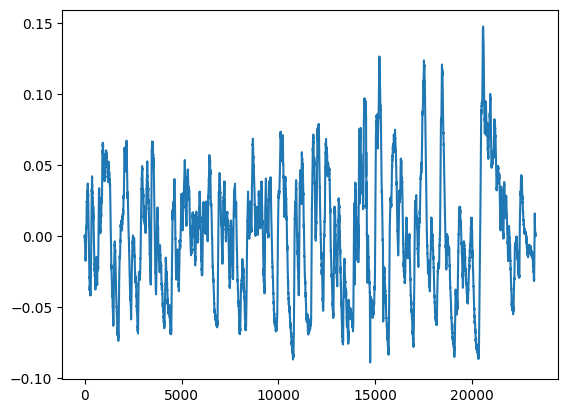

In [25]:
plt.plot(gsb1_ts[:, 0])

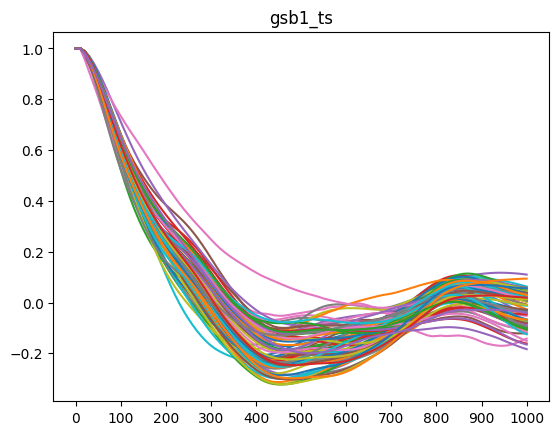

In [26]:
corrs = [autocorrelation(region, 1000, 10) for region in gsb1_ts.to_numpy().T]
corrs = np.array(corrs)

for i in range(corrs.shape[0]):
    plt.plot(corrs[i])
    plt.xticks(np.arange(0, 100 + 1, 10), np.arange(0, 1000 + 1, 100))

plt.title("gsb1_ts")
plt.show()

In [27]:
Tp = 300

X = gsb1_ts.to_numpy()[:, :10]
print(X.shape)
Y = X[Tp:]
X = X[:-Tp]


t = np.arange(len(X) // 2, len(X))
partition = len(X) // 2

obserbations, predictions = simplex_projection(X, Y, t, partition)

(23266, 10)


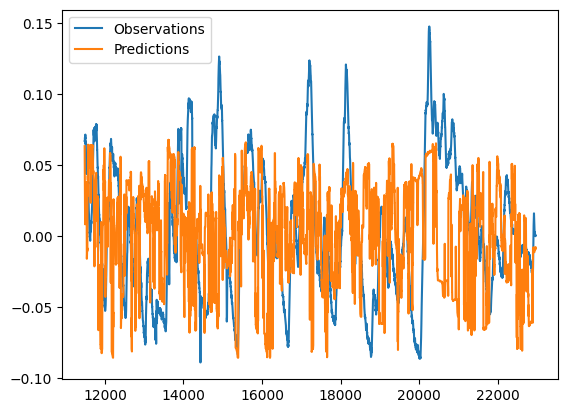

In [28]:
plt.plot(t, obserbations[:, 0], label="Observations")
plt.plot(t, predictions[:, 0], label="Predictions")

plt.legend()
plt.show()

In [29]:
np.corrcoef(obserbations[:, 0], predictions[:, 0])

array([[1.        , 0.07204581],
       [0.07204581, 1.        ]])

100%|██████████| 75/75 [00:11<00:00,  6.45it/s]


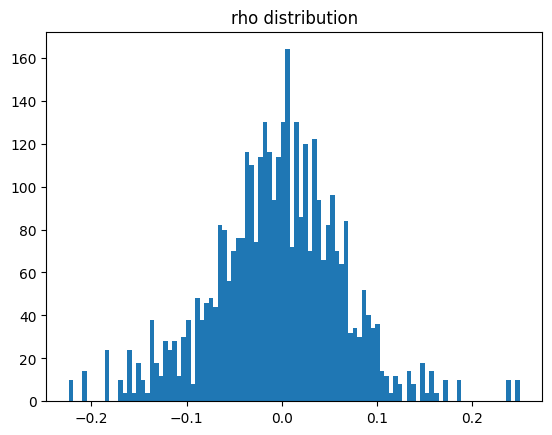

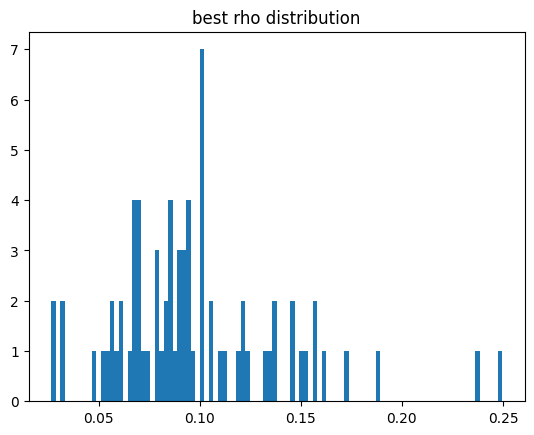

In [30]:
population = gsb1_ts.to_numpy().T
rho_matrix = np.zeros((len(population), len(tau_list), len(e_list)))

with tqdm.tqdm(total=len(population)) as pbar:
    for i, cell in enumerate(population):
        rho_matrix[i] = search_best_embedding(cell, tau_list, e_list, Tp, max_L=1000, rng=rng)
        pbar.update(1)

plt.hist(rho_matrix.flatten(), bins=100)
plt.title("rho distribution")
plt.show()

best_rho_indices = [np.unravel_index(np.argmax(rho, axis=None), rho.shape) for rho in rho_matrix]
best_rhos = [rho[index] for rho, index in zip(rho_matrix, best_rho_indices)]

plt.hist(best_rhos, bins=100)
plt.title("best rho distribution")
plt.show()

best_tau_e = [(tau_list[i], e_list[j]) for i, j in best_rho_indices]

In [31]:
best_tau_list, best_e_list = zip(*best_tau_e)

In [32]:
population.shape

(75, 23266)

In [33]:
min_L = 4000 - (max(best_e_list) - 1) * max(best_tau_list)

embeddings = [
    lagged_embed(cell[rng.choice(np.arange(cell.shape[0]), 4000, replace=False)], tau, e)[-min_L:]
    for cell, tau, e in zip(population, best_tau_list, best_e_list)
]

X = pad(embeddings)  # X.shape == (len(tau_list) * len(e_list), min_L, max(e_list))
D = pairwise_distance(Tensor(X, dtype=dtypes.float32)).numpy()

L = min_L
seq = np.arange(L)
lib_size = L // 2

N = X.shape[0]

rho = np.zeros((N, N))

samples_indecies = np.arange(lib_size, L)

with tqdm.tqdm(total=N * N) as pbar:
    for i in range(N):
        for j in range(N):
            observations = X[i, samples_indecies, : best_e_list[i]]
            predictions = np.zeros((len(samples_indecies), best_e_list[j]), dtype=embeddings[0].dtype)

            for k, t in enumerate(samples_indecies):
                # [0, 1, 2, 3, 4 | 5, 6, 7, 8, 9, 10]; initialize mask, `|` separates lib and test
                mask = np.ones(L, dtype=bool)

                # [0, 1, 2, 3, 4 | 5, F, 7, 8, 9, 10], t = 6; exclude self
                mask[t] = False

                # [0, 1, 2, 3, 4 | 5, F, 7, 8, F, F ], Tp = 2; exclude last Tp points to prevent out-of-bound indexing on predictions
                mask[-Tp:] = False

                # [0, 1, 2, 3, 4 | F, F, F, F, F, F ], lib_size = 5; exclude test points
                mask[lib_size:] = False

                # find k(=e+1) nearest neighbors in phase space for simplex projection
                indices_masked, _ = topk(D[i, t, mask], best_e_list[i] + 1, largest=False)
                indices = seq[mask][indices_masked]
                predictions[k] = X[j, indices, : best_e_list[j]].mean()

            ground_truth = X[j, samples_indecies, : best_e_list[j]]

            rho[i, j] = calculate_rho(ground_truth, predictions)
            pbar.update(1)

100%|██████████| 5625/5625 [1:08:00<00:00,  1.38it/s]   


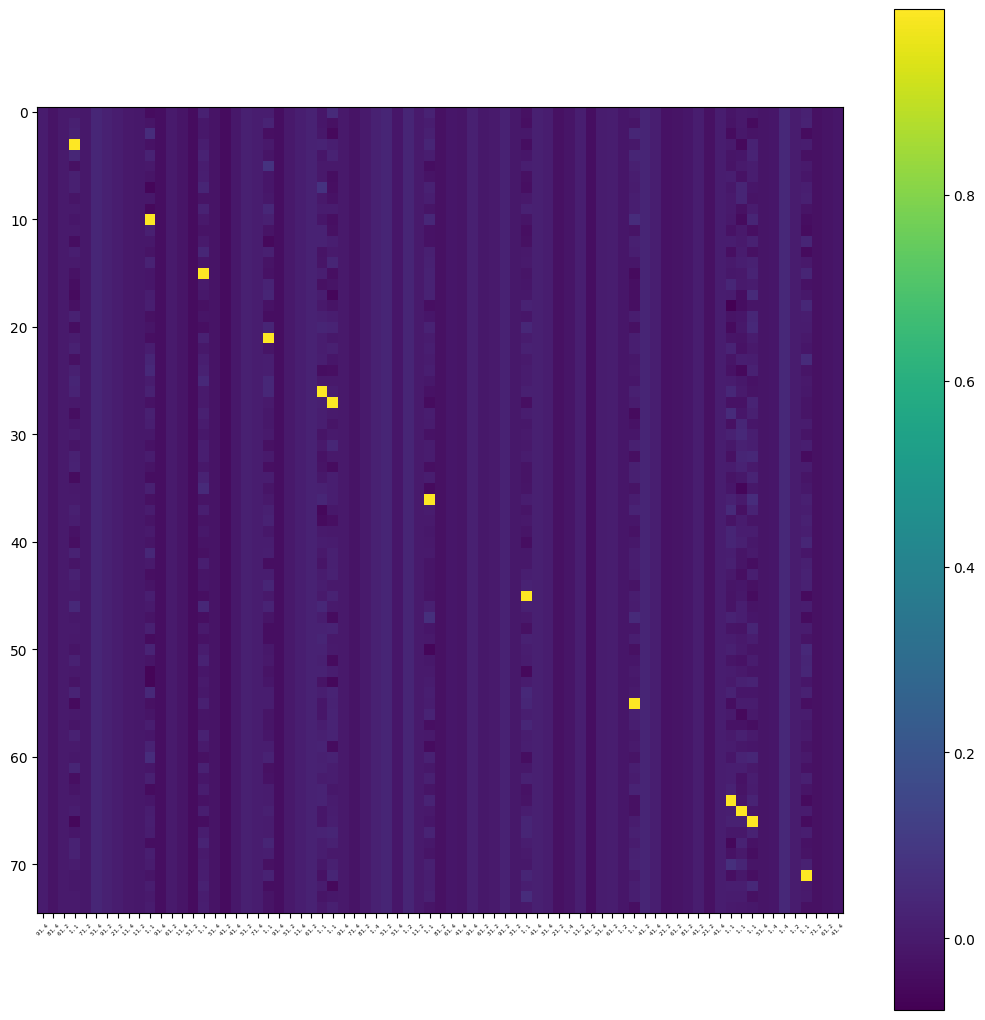

In [34]:
plt.figure(figsize=(13, 13))
plt.imshow(rho)
plt.xticks(np.arange(N), [f"{tau}, {e}" for tau, e in zip(best_tau_list, best_e_list)], fontsize=4, rotation=45)
plt.colorbar()

/Users/temma/Repositories/LabRotations/CHAOS/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


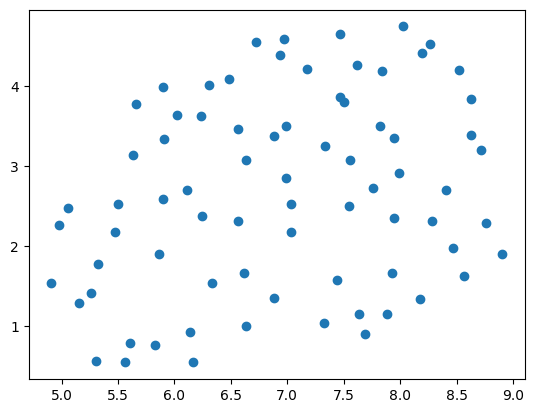

In [35]:
umap = UMAP(n_components=2).fit_transform(rho)

plt.scatter(umap[:, 0], umap[:, 1])